# SARIMA(p,d,q)(P,D,Q)m
# Seasonal Autoregressive Integrated Moving Averages
We have finally reached one of the most fascinating aspects of time series analysis: seasonality.

Where ARIMA accepts the parameters $(p,d,q)$, SARIMA accepts an <em>additional</em> set of parameters $(P,D,Q)m$ that specifically describe the seasonal components of the model. Here $P$, $D$ and $Q$ represent the seasonal regression, differencing and moving average coefficients, and $m$ represents the number of data points (rows) in each seasonal cycle.

<strong>NOTE:</strong> The statsmodels implementation of SARIMA is called SARIMAX. The “X” added to the name means that the function also supports <em>exogenous</em> regressor variables. We'll cover these in the next section.


<div class="alert alert-info"><h3>Related Functions:</h3>
<tt><strong>
<a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html'>sarimax.SARIMAX</a></strong><font color=black>(endog[, exog, order, …])</font>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<br>
<strong><a href='https://www.statsmodels.org/stable/generated/statsmodels.tsa.vector_ar.var_model.VARResults.html'>sarimax.SARIMAXResults</a></strong><font color=black>(model, params, …[, …])</font>&nbsp;&nbsp;Class to hold results from fitting a SARIMAX model.</tt>

<h3>For Further Reading:</h3>
<strong>
<a href='https://www.statsmodels.org/stable/statespace.html'>Statsmodels Tutorial:</a></strong>&nbsp;&nbsp;<font color=black>Time Series Analysis by State Space Methods</font></div>

In [1]:
import pandas as pd
import numpy as np

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # for determining (p,q) orders
from statsmodels.tsa.seasonal import seasonal_decompose      # for ETS Plots
from pmdarima import auto_arima                              # for determining ARIMA orders

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
'''

you'll often read in datasets and

they separate out the year and the month into columns like this.

So what we want to do is we want to figure out how we can use these two columns to create a date time

index.

'''
# Load dataset
df = pd.read_csv('../Data/co2_mm_mlo.csv')
df

,year,month,decimal_date,average,interpolated
0,1958,3,1958.208,315.71,315.71
1,1958,4,1958.292,317.45,317.45
2,1958,5,1958.375,317.50,317.50
3,1958,6,1958.458,NaN,317.10
4,1958,7,1958.542,315.86,315.86
...,...,...,...,...,...
724,2018,7,2018.542,408.71,408.71
725,2018,8,2018.625,406.99,406.99
726,2018,9,2018.708,405.51,405.51
727,2018,10,2018.792,406.00,406.00


We need to combine two integer columns (year and month) into a DatetimeIndex. We can do this by passing a dictionary into <tt>pandas.to_datetime()</tt> with year, month and day values.<br>
For more information visit https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.to_datetime.html

In [3]:
'''
We'll create a new column called Date and say, PD to date time, and then we can actually pass in a

dictionary call of what the year should be and what the month should be.And then if we want what the day should be

'''
df["date"]=pd.to_datetime({"year":df["year"],"month":df["month"],"day":1})

In [4]:
'''
And now if we check out the head of our data frame, we notice we have this date and it looks like it's

now a time stamp object,
'''
df

,year,month,decimal_date,average,interpolated,date
0,1958,3,1958.208,315.71,315.71,1958-03-01
1,1958,4,1958.292,317.45,317.45,1958-04-01
2,1958,5,1958.375,317.50,317.50,1958-05-01
3,1958,6,1958.458,NaN,317.10,1958-06-01
4,1958,7,1958.542,315.86,315.86,1958-07-01
...,...,...,...,...,...,...
724,2018,7,2018.542,408.71,408.71,2018-07-01
725,2018,8,2018.625,406.99,406.99,2018-08-01
726,2018,9,2018.708,405.51,405.51,2018-09-01
727,2018,10,2018.792,406.00,406.00,2018-10-01


In [5]:
'''
And you'll notice that the date column is, in fact, a date time object.
'''
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729 entries, 0 to 728
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   year          729 non-null    int64         
 1   month         729 non-null    int64         
 2   decimal_date  729 non-null    float64       
 3   average       722 non-null    float64       
 4   interpolated  729 non-null    float64       
 5   date          729 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(2)
memory usage: 34.3 KB


In [6]:
'''
Well, we still need to do, though, is we want this to actually be the index.

And now if I check the head of the data frame, I have my date index
'''

df.set_index("date")

,year,month,decimal_date,average,interpolated
date,,,,,
1958-03-01,1958,3,1958.208,315.71,315.71
1958-04-01,1958,4,1958.292,317.45,317.45
1958-05-01,1958,5,1958.375,317.50,317.50
1958-06-01,1958,6,1958.458,NaN,317.10
1958-07-01,1958,7,1958.542,315.86,315.86
...,...,...,...,...,...
2018-07-01,2018,7,2018.542,408.71,408.71
2018-08-01,2018,8,2018.625,406.99,406.99
2018-09-01,2018,9,2018.708,405.51,405.51


In [7]:
'''
the last thing to do in order to use stats models is that my frequency.
'''

df.index.freq="MS"

## Plot Source Data

<AxesSubplot:>

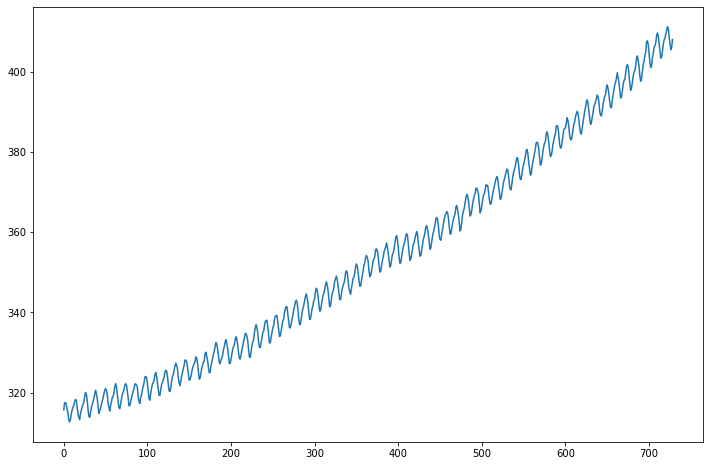

In [8]:
'''
Let's go ahead and plot out this data.

You'll notice that the average column is sometimes missing a few values.

So what they did instead is, they just interpolated it between the previous points and some of the future

points to fill in that value.

So we'll go ahead and use the interpolated column that we were not missing any points.

you should definitely see here that there are some clear seasonality as well as some general upward trend.
'''
df["interpolated"].plot(figsize=(12,8))

### Run an ETS Decomposition

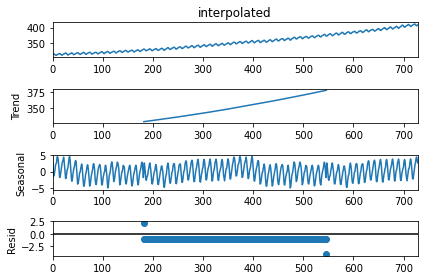

In [9]:
'''
And to confirm that there are some seasonality, we can run a decomposition so we can say results,

go ahead and say seasonal decompose on that interpolated column.

And you can use either an additive model or a multiplicative model, but the key thing to note here

is we'll definitely see a clear seasonal component.

So when we plot out this result, we can see here the observed values, the general trend.

And definitely by the scale, it's going to be large enough that we want to take that into account,

which is why we're using a seasonal Arima model.
'''

period=int(len(df)/2)
result=seasonal_decompose(df["interpolated"],model='add',period=period);
result.plot();

Although small in scale compared to the overall values, there is a definite annual seasonality.

### Run <tt>pmdarima.auto_arima</tt> to obtain recommended orders
This may take awhile as there are a lot more combinations to evaluate.

<AxesSubplot:>

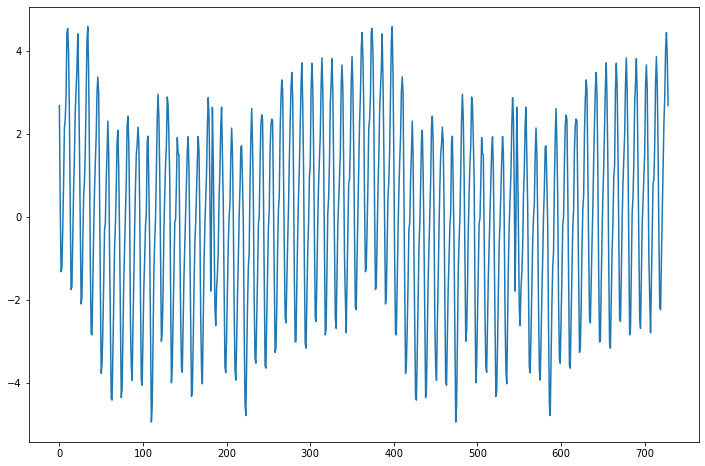

In [11]:
'''
If you were unsure about your particular data set and the seasonality cycle (M) of when you should set what

you should basically set equal to.

You could take the seasonal component of this result and then expand that, plot it out into different

sizes and then judge from there.

Plot that out and then you could start looking and maybe zoom in on this to see at what point does the

seasonal cycle repeat itself.

So we can see here the certain repetition.

You would just zoom in and see how many rows that take.
'''

result.seasonal.plot(figsize=(12,8))

In [10]:
'''
So because of that, let's go ahead and run the auto arima in order to obtain the recommended orders.


we pass df['interpolated'] on to auto Arima and then we want to make sure that we specify seasonals equal to true, even

though that technically is the default and because we specified seasonals equal to true, we need to

make sure we state how many rows are there per period.

And in this case, the seasonal is happening every year.

So say M is equal to 12 since we have monthly data and there's 12 months per year.
'''
auto_arima(df['interpolated'],seasonal=True,m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  729
Model:             SARIMAX(0, 1, 3)x(1, 0, [1], 12)   Log Likelihood                -205.686
Date:                              Fri, 05 Nov 2021   AIC                            423.371
Time:                                      15:07:23   BIC                            450.913
Sample:                                           0   HQIC                           433.998
                                              - 729                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3564      0.036     -9.820      0.000      -0.428      -0.285
ma.L2         -0.0221      0.034     -0.658      0.511      -0.088       0.044
ma.L3         -0.0856      0.031     -2.756      0.006      -0.146      -0.025
ar.S.L12       0.9996      0.000   3082.714      0.000       0.999       1.000
ma.S.L12      -0.8671      0.021    -41.245      0.000      -0.908      -0.826
sigma2         0.0955      0.005     20.304      0.000       0.086       0.105
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                 4.07
Prob(Q):                              0.79   Prob(JB):                         0.13
Heteroskedasticity (H):               1.13   Skew:                             0.00
Prob(H) (two-sided):                  0.33   Kurtosis:                         3.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [13]:
'''
Let's go ahead and do a train test, split on the data and test that our model, see how it performs

in the test set and then forecast into the future.

So we have 729 rows.

Let's go ahead and set one year for testing.
'''
len(df)

729

In [14]:
'''
So that means our training is going to be the df.Loc from the beginning, all the way to 717.
'''

train=df.iloc[:717]
test=df.iloc[717:]

Excellent! This provides an ARIMA Order of (0,1,3) combined with a seasonal order of (1,0,1,12) Now let's train & test the SARIMA(0,1,3)(1,0,1,12) model, evaluate it, then produce a forecast of future values.
### Split the data into train/test sets

### Fit a SARIMA(0,1,3)(1,0,1,12) Model

In [15]:
'''
So we're going to do now create the model.

We're going to pass in the interpolated column from the training data.

And here we're going to specify two parameters.

One is the first order for the Arima.

So AR, I, and MA of the normal Arima model.

That is going to be this first component here of (0,1,3).

And then the other one we're going to do is the seasonal order.

And that one's going to be the second one here, which is (1 0 1 12)

then we'll fit the model and get those results, so we'll a model

that fit.

Check the results summary.

And this is basically the same results or very similar results to what was just reported by Auto Arima,
'''

model=SARIMAX(train['interpolated'],order=(0,1,3),seasonal_order=(1,0,1,12))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                         interpolated   No. Observations:                  717
Model:             SARIMAX(0, 1, 3)x(1, 0, [1], 12)   Log Likelihood                -201.196
Date:                              Fri, 05 Nov 2021   AIC                            414.391
Time:                                      15:29:16   BIC                            441.833
Sample:                                           0   HQIC                           424.988
                                              - 717                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3541      0.036     -9.908      0.000      -0.424      -0.284
ma.L2         -0.0246      0.035     -0.707      0.479      -0.093       0.044
ma.L3         -0.0874      0.035     -2.486      0.013      -0.156      -0.018
ar.S.L12       0.9996      0.000   2909.812      0.000       0.999       1.000
ma.S.L12      -0.8649      0.023    -37.958      0.000      -0.910      -0.820
sigma2         0.0951      0.005     20.274      0.000       0.086       0.104
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                 4.28
Prob(Q):                              0.78   Prob(JB):                         0.12
Heteroskedasticity (H):               1.15   Skew:                             0.02
Prob(H) (two-sided):                  0.29   Kurtosis:                         3.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
'''
Now, let's go ahead and get predicted values for our test set range.

And now let's create some predictions by simply calling results.predict( the start of the end and

we'll go ahead and say type is levels) to make sure we don't have any sort of issues of any difference

in components.

And then we'll rename it.
'''
start=len(train)
end = len(train)+len(test)-1
predictions=results.predict(start,end,type='levels').rename("SARIMA Predictions")
predictions

717    406.610447
718    407.826126
719    408.579543
720    409.484660
721    411.043312
722    411.646671
723    410.865698
724    409.174774
725    407.074523
726    405.624632
727    405.896054
728    407.430499
Name: SARIMA Predictions, dtype: float64

Passing <tt>dynamic=False</tt> means that forecasts at each point are generated using the full history up to that point (all lagged values).

Passing <tt>typ='levels'</tt> predicts the levels of the original endogenous variables. If we'd used the default <tt>typ='linear'</tt> we would have seen linear predictions in terms of the differenced endogenous variables.

For more information on these arguments visit https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima_model.ARIMAResults.predict.html

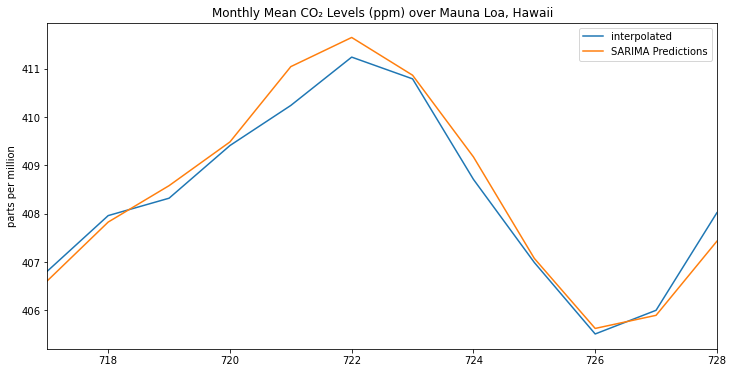

In [23]:
'''
So we run that, we have our predictions, so let's go ahead and plot them out against the test results,

here we can see the real blue interpolating results and the Sarino predictions.

So as you can tell for predicting about a year out, we're actually a pretty good.

Again, remember that our SARIMA model actually does not know what this data should be.

And we can see compared to the real data, it's pretty on target.
'''
# Plot predictions against known values
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel=''

ax = test['interpolated'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [42]:
'''
So if we actually want to evaluate the model, we can always do things such as import root, mean squared

error.

'''

from sklearn.metrics import  mean_squared_error
error=mean_squared_error(test['interpolated'],predictions)
print(f'SARIMA(0,1,3)(1,0,1,12) MSE Error: {error:11.10}')


SARIMA(0,1,3)(1,0,1,12) MSE Error: 0.1284765781


In [43]:
'''
And then my error would be something like our RMSE.

Test interpolated compared to our predictions,
'''
from statsmodels.tools.eval_measures import rmse
error=rmse(test['interpolated'],predictions)
print(f'SARIMA(0,1,3)(1,0,1,12) RMSE Error: {error:11.10}')

SARIMA(0,1,3)(1,0,1,12) RMSE Error: 0.3584362958


### Retrain the model on the full data, and forecast the future

In [45]:
'''
Fit Entire data into model

And let's go on to predict one year into the future.

And we don't want to output the different results.

We want to put the true results in the same units as the original data.

so type='levels'

'''
model=SARIMAX(df['interpolated'],order=(0,1,3),seasonal_order=(1,0,1,12))
results=model.fit()
fcast = results.predict(len(df),len(df)+11,typ='levels').rename('SARIMA(0,1,3)(1,0,1,12) Forecast')


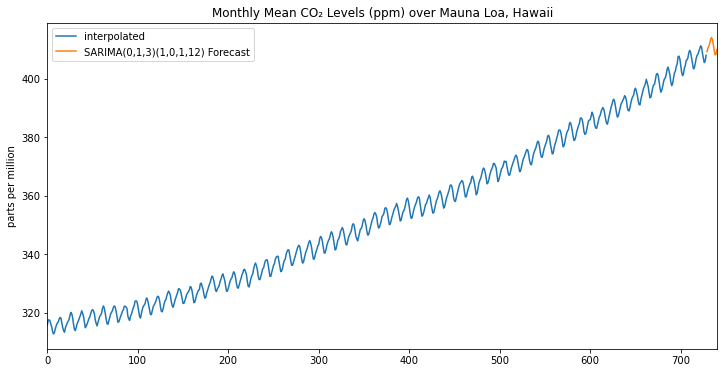

In [46]:
'''
So when we run that, we can see here at the very end what our forecast is.

'''

# Plot predictions against known values
title = 'Monthly Mean CO₂ Levels (ppm) over Mauna Loa, Hawaii'
ylabel='parts per million'
xlabel=''

ax = df['interpolated'].plot(legend=True,figsize=(12,6),title=title)
fcast.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);